# Operator Inference with Optimization for Burger's Equation

Here we implment the operator inference solved with a non-constrained optimization approach rather than a linear least square approach shown in [Notebook 02](02_burgers_OpInf_LS.ipynb). This is the reproduction of the results from [Peherstorfer and Willcox](https://www.sciencedirect.com/science/article/pii/S0045782516301104?via%3Dihub).

## Initial Setup

In [1]:
using DataFrames
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10, "dirichlet"
);

## Non-Constrained Optimization

In [2]:
num_inputs = 10
rmax = 15

options = LnL.NC_options(
    system=LnL.sys_struct(
        is_lin=true,
        is_quad=true,
        has_control=true,
        has_output=true,
    ),
    vars=LnL.vars(
        N=1,
    ),
    data=LnL.data(
        Δt=1e-4,
        deriv_type="SI",
        DS=100,
    ),
    optim=LnL.opt_settings(
        verbose=false,
        initial_guess=false,
    ),
)

Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
k = 3
proj_err = zeros(rmax - k, burger.Pdim)
intru_state_err = zeros(rmax - k, burger.Pdim)
opinf_state_err = zeros(rmax - k, burger.Pdim)
intru_output_err = zeros(rmax - k, burger.Pdim)
opinf_output_err = zeros(rmax - k, burger.Pdim)

# Downsampling rate
DS = options.data.DS

println("[INFO] Compute inferred and intrusive operators and calculate the errors")
for i in 1:length(burger.μs)
    μ = burger.μs[i]

    ## Create testing data
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    Xtest = LnL.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
    Ytest = C * Xtest

    op_burger = LnL.operators(A=A, B=B, C=C, F=F)

    ## training data for inferred dynamical models
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = burger.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    X = reduce(hcat, Xall)
    R = reduce(hcat, Xdotall)
    Urand = Urand[1:DS:end, :]  # downsample data
    U = vec(Urand)[:,:]  # vectorize
    Y = C * X

    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]

    # Compute the values for the intrusive model from the basis of the training data
    op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

    # Compute the inferred operators from the training data
    if options.optim.reproject
        op_inf = LnL.inferOp(X, U, Y, Vrmax, op_burger, options, op_int)  # Using Reprojection
    else
        op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options, op_int)  # without reprojection
    end

    for j = 1+k:rmax
        Vr = Vrmax[:, 1:j]  # basis
        
        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, j)
        Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], op_int.B[1:j, :], Fint_extract, Utest, burger.t, Vr' * burger.IC)  # use F
        Yint = op_int.C[1:1, 1:j] * Xint
        
        # Integrate the inferred model
        Finf_extract = LnL.extractF(op_inf.F, j)
        Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], op_inf.B[1:j, :], Finf_extract, Utest, burger.t, Vr' * burger.IC)  # use F
        Yinf = op_inf.C[1:1, 1:j] * Xinf

        # Compute errors
        PE, ISE, IOE, OSE, OOE = LnL.compError(Xtest, Ytest, Xint, Yint, Xinf, Yinf, Vr)

        # Sum of error values
        proj_err[j-k, i] = PE
        intru_state_err[j-k, i] = ISE
        intru_output_err[j-k, i] = IOE
        opinf_state_err[j-k, i] = OSE
        opinf_output_err[j-k, i] = OOE
    end
end

[INFO] Compute inferred and intrusive operators and calculate the errors


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.11399984359741211
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 5.867817905318119e9
│ objective_value      = 18.511186221052807
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:158
┌ Info: Optimize model.


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:174


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.019999980926513672
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 5.805615595148159e9
│ objective_value      = 4.415870194502516
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimi

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.04500007629394531
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.069538170673601e9
│ objective_value      = 1.1037105857349663
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Main.L

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.018000125885009766
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.125293230851338e9
│ objective_value      = 0.38956055334239675
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize opti

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:174


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.019999980926513672
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.866461994112502e9
│ objective_value      = 0.19321375124085532
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize opti

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.021000146865844727
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.216249595152592e9
│ objective_value      = 0.08951405659686067
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Main

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:174


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.029000043869018555
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.492400588259817e9
│ objective_value      = 0.04638395034449047
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize opti

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.034999847412109375
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.69605562146646e9
│ objective_value      = 0.02956642455265899
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Main.

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.01699995994567871
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 7.205263372965143e9
│ objective_value      = 0.016478278599488156
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Main

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:101
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:104
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.020999908447265625
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.729646483650086e9
│ objective_value      = 0.012228175712032023
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:106
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:127
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:148
┌ Info: Done.
└ @ Mai

## Results

In [8]:
proj_err_mean = nanmean(proj_err, dims=2)
intru_state_err_mean = nanmean(intru_state_err, dims=2)
intru_output_err_mean = nanmean(intru_output_err, dims=2)
opinf_state_err_mean = nanmean(opinf_state_err, dims=2)
opinf_output_err_mean = nanmean(opinf_output_err, dims=2)

df = DataFrame(
    order=1+k:rmax,
    projection_err=vec(proj_err_mean),
    intrusive_state_err=vec(intru_state_err_mean),
    intrusive_output_err=vec(intru_output_err_mean),
    inferred_state_err=vec(opinf_state_err_mean),
    inferred_output_err=vec(opinf_output_err_mean)
)

Row,order,projection_err,intrusive_state_err,intrusive_output_err,inferred_state_err,inferred_output_err
,Int64,Float64,Float64,Float64,Float64,Float64
1,4,0.00920187,0.0135034,0.387776,0.0134887,1.0
2,5,0.004586,0.00656335,0.376965,0.00655112,1.0
3,6,0.00216441,0.00302233,0.371895,0.00301848,1.0
4,7,0.00102552,0.00141838,0.366858,0.00141663,1.0
5,8,0.000476708,0.000646239,0.363552,0.000650988,1.0
6,9,0.000234615,0.000307322,0.359645,0.000334036,1.0
7,10,0.000109312,0.000144399,0.354919,0.000156605,1.0
8,11,5.26027e-5,6.68176e-5,0.34931,0.000196724,1.0
9,12,2.45409e-5,3.11098e-5,0.343812,8.03144e-5,1.0


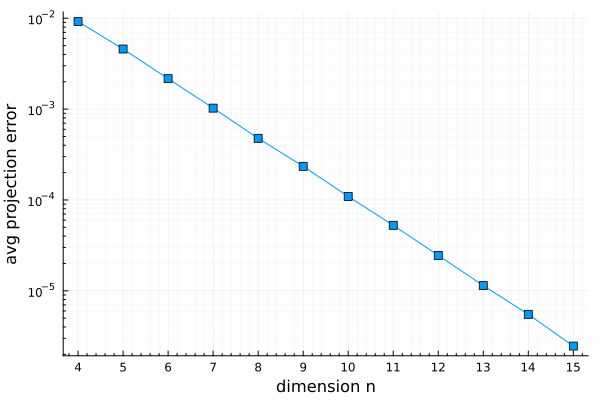

In [9]:
# Projection error
plot(df.order, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(df.projection_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg projection error")

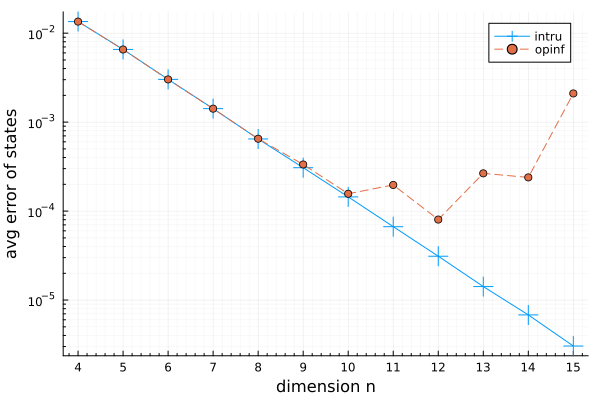

In [10]:
# State errors
plot(df.order, df.intrusive_state_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)

yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of states")

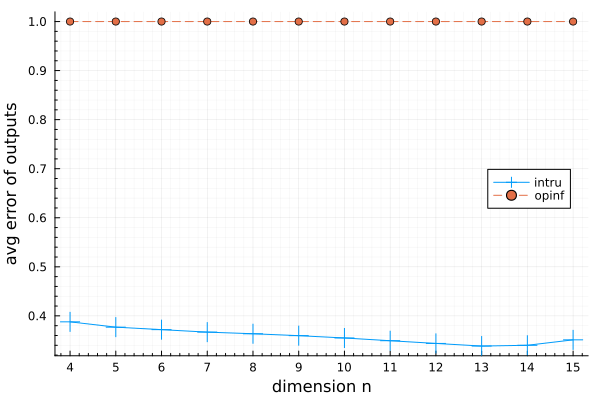

In [11]:
# Output errors
plot(df.order, df.intrusive_output_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_output_err, marker=(:circle), ls=:dash, label="opinf")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of outputs")